# Oscillator Model

### Physics-068 Spring 2020
### Authors: 
- Jacob Sunnerberg 
- John Davis 
- Kai Stewart

This computational notebook describes the damped harmonic oscillator system of a steel ball bearing rolling inside of a half-pipe track under the influence of gravity. The track was cut from two pieces of wood using the shape/potential function $y = \frac{1}{16}x^2$.

Experimental data for steel bearings of two different sizes was taken in the form of 120fps video files and analyed using the phyiscs object tracking software [Tracker](https://physlets.org/tracker/). Tracker was used to generate the .cvs data files used in the computation of out analytical model.

---

### System Lagrangian
The Lagrange Equation of the first kind is:

$\mathcal{L} = K_E - U$

For our experiment, the kinetic energy is given by the usual $K_E = \frac{1}{2}m\dot{x}^2$ and the potential is given by our wooden half-pipe track, cut using the equation $U(x) = \frac{1}{16}x^2$.

The Lagrangian for our system is then:

$\mathcal{L} = \frac{1}{2}m\dot{x}^2 - \frac{1}{16}x^2$

With derivatives:

$\frac{\partial \mathcal{L}}{\partial x} = -\frac{1}{8}x$

$\frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot{x}} = m\ddot{x}$

The equation of motion for which we need to solve is then:

$m\ddot{x} + \frac{1}{8}x = 0$

The characteristic equation and its solutions are:

$mr^2 + \frac{1}{8} = 0; \hspace{5mm} r = \pm \frac{i}{\sqrt{8m}}$

Using the general form for the solution of a second order differential equation, we get:

$x(t) = c_1 e^{0t}\cos\big(\frac{t}{\sqrt{8m}}\big) + c_2 e^{0t}\sin\big(\frac{t}{\sqrt{8m}}\big)$

$x(t) = c_1 \cos\big(\frac{t}{\sqrt{8m}}\big) + c_2\sin\big(\frac{t}{\sqrt{8m}}\big)$

The initial values for our oscillator system are $x(0) = h, x'(0) = 0$

$x(0) = c_1 \cos(0) + c_2\sin(0) = h; \hspace{5mm} x(0) = c_1 = h$

$x'(0) = -\frac{c_1}{\sqrt{8m}}\sin(0) + \frac{c_2}{\sqrt{8m}}\cos(0) = 0; \hspace{5mm} \therefore c_2 = 0$

$x(t) = h \cos\big(\frac{t}{\sqrt{8m}}\big)$

This position function still requires the inclusion of a dampening factor. We wish to find a final representation of the general form:

$x(t) = A \cos\big(\omega t - \phi \big)e^{-\gamma t}$

To find the dampening factor $\gamma$, we convert our position-vs-time function to a logarithmic representation as:

$ x_{\text{log}}(t) = A\log\big |\cos(\omega t - \phi)e^{-\gamma t}\big | = -A\gamma t\log\big |\cos(\omega t - \phi)\big |$

From $x_{\text{log}}(t)$ we can compute a linear regression against the values of the oscillation peak positions, the slope of which corresponds to the value of the dampening factor $\gamma$.

---

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Experimental Constants

In [2]:
# Large Ball
lg_mass = .06907 # Mass in kg
lg_h0 = 0.2032 # Initital height in meters
lg_constants = [lg_mass, lg_h0, 'Large Ball no Magnet']
lg_mag_constants = [lg_mass, lg_h0, 'Large Ball with Magnet']

# Small Ball
sm_mass = 0.0291 # Mass in kg
sm_h0 = 0.2159 # Initital height in meters
sm_constants = [sm_mass, sm_h0, 'Small Ball no Magnet']
sm_mag_constants = [sm_mass, sm_h0, 'Small Ball with Magnet']

# Functions

### Model Function
- This function first instantiates our analytical oscillator model as the function $h\sin(\omega t + \phi)$
- If a dampening factor(s) is given, this function computes the model as: 
    - $h\sin(\omega t + \phi)\Pi_i e^{-\gamma_i t}$ for each factor $\gamma_i$ supplied to the function.

#### Arguments:
    - h (float) the initial height of the ball at the start of the experiment
    - step (float) the time step for which the model is calculating the oscillator position
    - phi (float) phase angle
    - gamma (float or list) dampening factor
#### Returns:
    - model (float) single position value for the oscillator model.

In [3]:
def model_function(h, omega, step, phi, gamma=None):
    model = h * np.cos(omega * step - phi)
    if isinstance(gamma, list):
        exp = []
        for i in range(len(gamma)):
            exp.append(np.exp(gamma[i] * step))
        for i in range(len(exp)):
            model *= exp[i]
        return model
    else:
        return model*np.exp(gamma * step) if gamma is not None else model

### Model
- Function that returns a model solution for the oscillator experiment analytically derived from the Lagrangian of the system, with optional dampening factor.

#### Args:
    - h (float) the initial height of the ball at the start of the experiment
    - t (array) list of floating point numbers corresponding to the time over which the oscillation takes place
    - m (float) mass of the ball whose oscillation is being modeled
    - gamma (float or list, optional): dampening factor derived from fitting a line to the peaks of the log-space representation of the oscillator position v. time data.

#### Returns:
    - model (Numpy Array) representation of the system using the given parameters, with or without damping

In [4]:
def model(h, t, m, gamma=None):
    # Make sure t is an np array
    if not isinstance(t, np.ndarray):
        t = np.asarray(t)

    # Compute the oscillator model
    ## Set the oscillation frequency (see above derivation)
    if m < 0.5: num = 0.8
    else: num = 1.25
    omega = num/np.sqrt(m)
    
    ## Set the phase
    phase = np.asarray([np.pi/2] * len(t))
    
    if gamma is not None:
        return np.asarray([model_function(h, omega, step, phi, gamma) for step, phi in zip(t, phase)])
    return np.asarray([model_function(h, omega, step, phi) for step, phi in zip(t, phase)])

### Get Experimental Data
- Function that loads experimental data stored in a .csv file as a numpy array and combines it with experimental constants supplied for a particular steel ball bearing.

#### Args:
    - datafile (str) path to csv datafile produced by tracker software.
    - constants (list) collection of constants for a steel ball bearing (see constants above).
#### Returns:
    - list:
        - 1st position: numpy array of sorted time values
        - 2nd position: numpy array of x-position values
        - 3rd position: numpy array of y-position values
        - 4th position: appended list of constants

In [5]:
def get_exp_data(datafile, constants):
    data = pd.read_csv(datafile)
    if not isinstance(constants, list):
        raise TypeError('Constants must be a list!')
    return [sorted(data['t'].values), data['x'].values, data['y'].values] + constants

### Get Regression Point
- Function that quickly computes a point for use with a linear regression computation

#### Arguments:
    - t (array or list) time step values
    - s (float) slope of the regression line
    - i (float) intercept point of the regression line
#### Returns:
    - regression point (float)

In [6]:
def get_reg_point(t, s, i):
    return t * s + i

### Get Regression
- Function that computes a linear regression

#### Arguments:
    - t (array or list) time step values
    - s (float) slope of the regression line
    - i (float) intercept point of the regression line
#### Returns:
    - list of regression values

In [7]:
def get_reg(t, s, i):
    return [ get_reg_point(step, s, i) for step in t ]

### Logarithmic Space
- Function that converts an array of position information to logarithmic space.
- The minimum value of the oscillation data is subtracted away in order to shift the data.
        
### Arguments:
    - x (Numpy Array) array of values corresponding to ball position in experimental data
    - x_min (float) minimum value of the x-position relative to the bottom of the potential well
### Returns:
    - log_pos (Numpy Array) position values converted to logarithmic space

In [8]:
def log_space(t, x, x_min):
    # Convert the x-position data to log-space
    log_pos = np.log(np.absolute(x-x_min))
    
    # Get the locations of the  oscillation peaks from the log-space position data
    peaks, height = get_peaks(log_pos)

    # Compute a linear regression against the peak location values
    slope, intercept, _, _, _ = stats.linregress(t[peaks], log_pos[peaks])
    log_reg = get_reg(t, slope, intercept)
    
    # Set the dampening factor
    gamma = [slope]
    
    return log_pos, log_reg, peaks, height, slope, gamma

### Get Peaks
- Function that finds the peaks in a periodic signal and returns the respective indices.  
[SciPy Find Peak Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

#### Arguments:
    - log_pos (Numpy array) logarithmic position information of the oscillator
#### Returns:
    - peaks (Numpy array) integer values corresponding to the peak locations in the data.
    - height (int) value corresponding to the cutoff value for data incluxded in the peak finding computation.

In [9]:
def get_peaks(log_pos):
    # Set the minimum cutoff value
    floor = min(log_pos)
    
    # Set the height threshold for the peak finding algorithm
    height = floor + 2
    
    # Find the peaks of the logarithmic plot
    peaks, _ = find_peaks(log_pos, height=height)

    return peaks, height

### Compute Experiment
- Function that computes and plots various components of the oscillator experiment.

#### Arguments:
    - t (array):  time values corresponding to the experiment
    - x (array):  x-position values corresponding to the experiemnt
    - y (array):  y-position values corresponding to the experiment
    - m (float):  mass of the ball being modeled
    - h0 (float): height from which the ball was released into the potential
    - savename (str): string name for output .png file
#### Returns:
    - Nothing

In [10]:
def compute_experiment(t, x, y, m, h0, savename):
    # Make sure data is np array datatype
    t = np.array(t); x = np.array(x); y = np.array(y)
    fig, axes = plt.subplots(2, 2, figsize=(20,10))
    
    # Set figure title
    title = savename.replace("_", " ")
    plt.suptitle(title, fontsize=18)
    
    ## Set font sizes
    l_font = 12; t_font = 14

    ## Find min of y-data
    idx = np.argmin(y)
    x_min = x[idx]; y_min = y[idx]
    
    ## Set the oscillation amplitude based on experimental data
    h0 = np.absolute(x[0] - max(x))/2
    
    ### Experimental Data Plot ###
    axes[0][0].plot(t, x-x_min, label='Experimental Data') # Here we shift the data down to the x-axis
    axes[0][0].set_title('Position v. Time', fontsize=t_font)
    axes[0][0].set_xlabel('Time [s]', fontsize=l_font)
    axes[0][0].set_ylabel('X-Position [m]', fontsize=l_font)
    axes[0][0].grid()
    axes[0][0].legend()

    ### X versus Y (Ball in Potential) ###
    axes[0][1].plot(x, y)
    axes[0][1].plot(x_min, y_min, 'x', label=f'min_x: {round(x_min, 3)}')
    axes[0][1].set_title('X-Position v. Y-Position', fontsize=t_font)
    axes[0][1].set_xlabel('X-Position [m]', fontsize=l_font)
    axes[0][1].set_ylabel('Y-Position [m]', fontsize=l_font)
    axes[0][1].legend()

    ### Conversion to Logarithmic Space ###
    ### and computation of gamma factor ###
    log_pos, log_reg, peaks, height, slope, gamma = log_space(t, x, x_min)
    
    ### Plot Logarithmic representation ###
    axes[1][0].plot(t, log_pos)
    
    # Plot the log-regression against the peak locations
    axes[1][0].plot(t[peaks], log_pos[peaks], color='green', marker="x")
    axes[1][0].plot(t, log_reg, color='orange', label=f"Log_Reg_Slope: {round(slope, 3)}")    
    
    # Beautify
    axes[1][0].axhline(height, linestyle='--', color='gray')
    axes[1][0].set_title('Log|x|-Position v. Time', fontsize=t_font)
    axes[1][0].set_xlabel('Time [s]', fontsize=l_font)
    axes[1][0].set_ylabel('X-Position [m]', fontsize=l_font)
    axes[1][0].legend()
    
    ### Compute the analytical model ###
    ## Model without damping
    pred = model(h0, t, m, gamma=None)
    axes[1][1].plot(t, pred, linestyle='--', color='magenta', label='No Damping')
    
    ## Model with damping
    pred = model(h0, t, m, gamma=gamma)
    axes[1][1].plot(t, pred, linestyle='--', color='green', label=f'Damping [$\gamma$]: {round(slope, 3)}')
    
    # Overlay the experimental data
    axes[1][1].plot(t, x-x_min, color='b', label='Exp_Data')
    
    # Beautify
    axes[1][1].set_title('Analytical Model: $x(t) = h\sin(\omega t - \phi)e^{-\gamma t}$', fontsize=t_font)
    axes[1][1].set_xlabel('Time [s]', fontsize=l_font)
    axes[1][1].set_ylabel('X-Position [m]', fontsize=l_font)
    axes[1][1].grid()
    axes[1][1].legend(ncol=3, loc='lower center')
    
    plt.savefig(f'{savename}.png', dpi=300)

# Compute the oscillator model and compare with exp. data

## Compute the model and plot

### Small Ball - No Magnet Present

In [11]:
sm_args = get_exp_data('sm_ball_no_mag.csv', sm_constants)

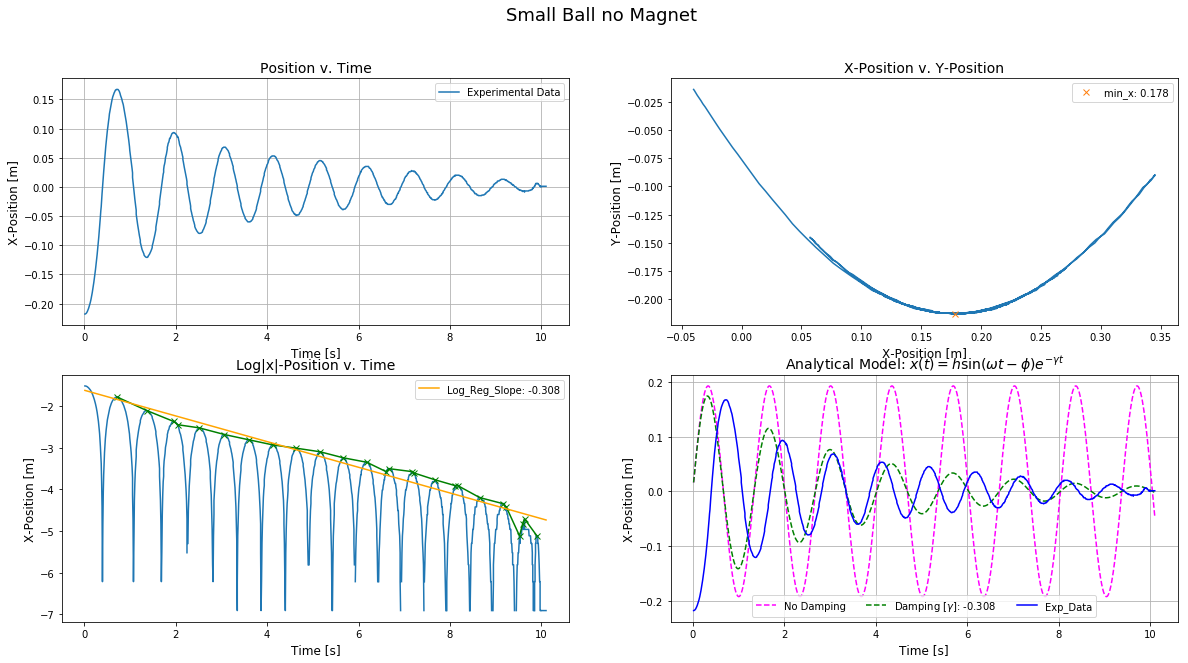

In [12]:
compute_experiment(*sm_args)

### Small Ball - Magnet Present

In [13]:
sm_mag_args = get_exp_data('sm_ball_w_mag.csv', sm_mag_constants)

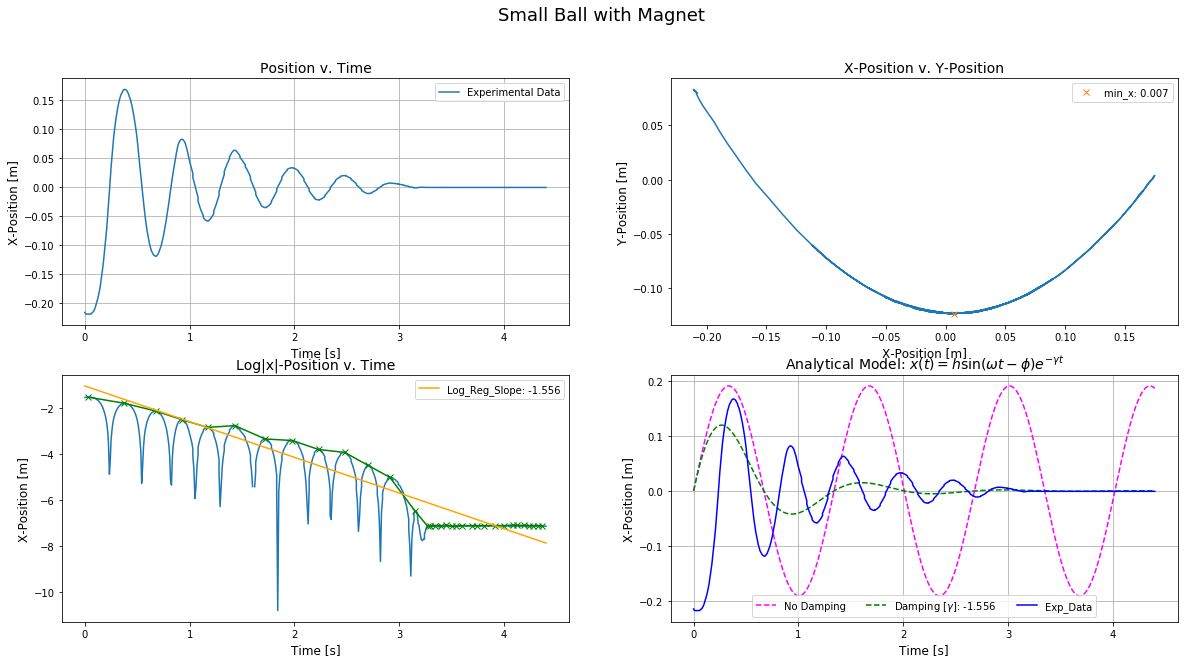

In [14]:
compute_experiment(*sm_mag_args)

### Large Ball - No Magnet Present

In [15]:
lg_args = get_exp_data('lg_ball_no_mag.csv', lg_constants)

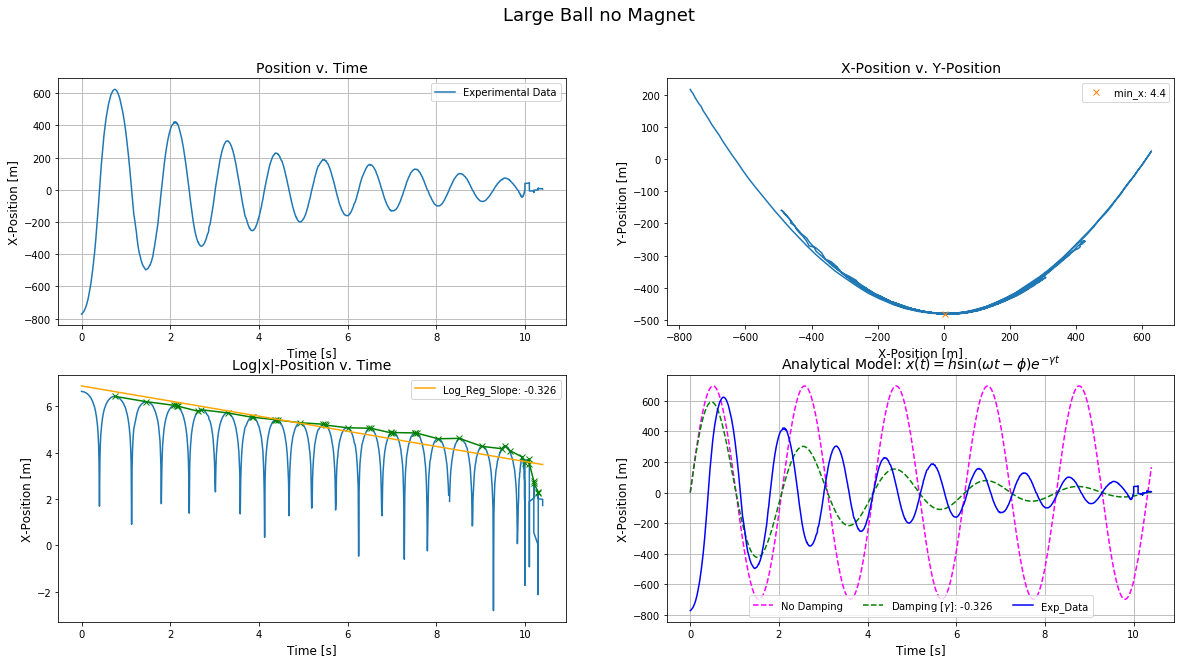

In [16]:
compute_experiment(*lg_args)

### Large Ball - Magnet Present

In [17]:
lg_mag_args = get_exp_data('lg_ball_w_mag.csv', lg_mag_constants)

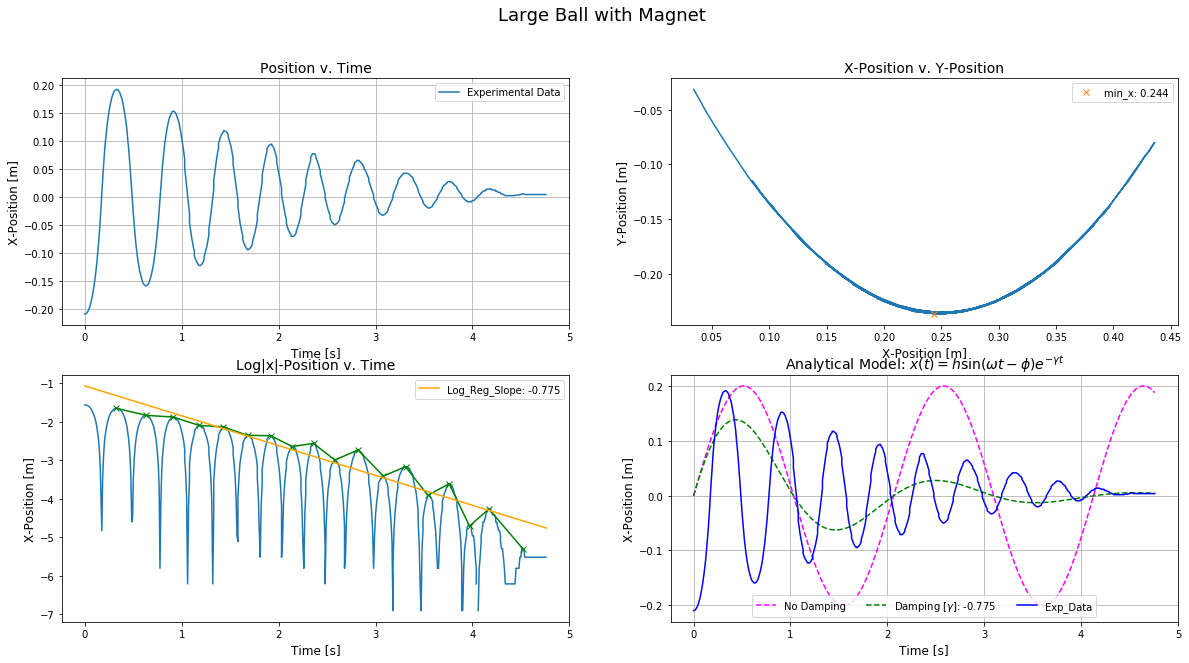

In [18]:
compute_experiment(*lg_mag_args)